In [1]:
import json 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random

import string
# import nltk
from nltk import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D , Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import callbacks

In [2]:
with open("../data/Intent.json") as train_file:
    df= json.load(train_file)

# TOKENIZATION

In [3]:
df["intents"][0]["intent"]

'Greeting'

In [4]:
tags = []
inputs = []
responses = {}

for intent in df['intents']:
    responses[intent['intent']] = intent['responses']
    for lines in intent['text']:
        inputs.append(lines)
        tags.append(intent['intent'])
df = pd.DataFrame({'inputs': inputs, 'tags': tags})
df

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting
...,...,...
138,Can you prove you have a conscious,SelfAware
139,Can you prove you are self-aware please,SelfAware
140,Can you prove you are self aware please,SelfAware
141,Can you prove you have a conscious please,SelfAware


In [5]:
df["inputs"] = df["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
df["inputs"] = df["inputs"].apply(lambda wrd:"".join(wrd))

In [6]:
# Tokenizer les data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df["inputs"])
train = tokenizer.texts_to_sequences(df["inputs"])

In [53]:
# apply padding
#x_train = pad_sequences(train)
X_data = pad_sequences(train)

In [58]:
#encoding the outputs
le = LabelEncoder()
#Y_train = le.fit_transform(df['tags'])
y_data = le.fit_transform(df['tags'])

In [55]:
#input_shape = x_train.shape[1]
input_shape = X_train.shape[1]
print(input_shape)

9


In [56]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words :",vocabulary)
output_length = le.classes_.shape[0]
print("output length ", output_length)

number of unique words : 117
output length  22


# Premier model sans train-test split ! 

In [11]:
from sklearn.model_selection import train_test_split

In [61]:
#X_train_data, X_test, y_train_data, y_test = train_test_split(x_train, Y_train, test_size=0.1, random_state=42, stratify=Y_train)
X_train_data, X_test, y_train_data, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42, stratify=y_data)

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42, stratify=y_train_data)

In [37]:
pd.DataFrame(y_train)[0].value_counts()

8     6
0     5
19    5
2     5
16    5
15    5
14    5
13    5
12    5
11    5
3     5
4     5
7     5
6     4
1     4
21    4
9     4
20    4
18    4
10    4
5     3
17    3
Name: 0, dtype: int64

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 9)
(43, 9)
(100,)
(43,)


In [14]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words :",vocabulary)
output_length = le.classes_.shape[0]
print("output length ", output_length)

number of unique words : 117
output length  22


# LTSM

In [71]:
lstm_model = Sequential()
lstm_model.add(InputLayer(input_shape=(input_shape,)))
lstm_model.add(Embedding(vocabulary+1,10))
lstm_model.add(LSTM(10, return_sequences=True))
lstm_model.add(Flatten())
lstm_model.add(Dense(output_length, activation="softmax"))

In [72]:
#compile the model
lstm_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [73]:
# early_stopping = callbacks.EarlyStopping(
#     patience=20,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [74]:
# early_stop = callbacks.EarlyStopping(monitor="loss",mode="min",verbose=1,patience=100)

In [75]:
# history = model_sw.fit(x_train, Y_train, epochs=100)
history = lstm_model.fit(X_train,y_train, epochs=100, validation_data=(X_val, y_val))
#history = lstm_model.fit(X_train,y_train, epochs=100, validation_split=0.2)
# history = lstm_model.fit(X_train,y_train, epochs=100, validation_split=0.3,callbacks=[early_stopping])
# pas de batch_size ?!

Epoch 1/100
3/3 [==============================] - 3s 331ms/step - loss: 3.0907 - accuracy: 0.0208 - val_loss: 3.0897 - val_accuracy: 0.0400
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 3.0882 - accuracy: 0.0312 - val_loss: 3.0888 - val_accuracy: 0.1200
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 3.0861 - accuracy: 0.1042 - val_loss: 3.0879 - val_accuracy: 0.1600
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 3.0840 - accuracy: 0.1458 - val_loss: 3.0870 - val_accuracy: 0.1200
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 3.0820 - accuracy: 0.1667 - val_loss: 3.0860 - val_accuracy: 0.1200
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 3.0798 - accuracy: 0.1667 - val_loss: 3.0850 - val_accuracy: 0.1600
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 3.0775 - accuracy: 0.1667 - val_loss: 3.0838 - val_accuracy: 0.2000
Epoch 8/100
3/3 [==

3/3 [==============================] - 0s 22ms/step - loss: 1.9013 - accuracy: 0.4792 - val_loss: 2.2815 - val_accuracy: 0.4000
Epoch 60/100
3/3 [==============================] - 0s 21ms/step - loss: 1.8632 - accuracy: 0.4792 - val_loss: 2.2544 - val_accuracy: 0.4800
Epoch 61/100
3/3 [==============================] - 0s 21ms/step - loss: 1.8264 - accuracy: 0.4896 - val_loss: 2.2258 - val_accuracy: 0.4800
Epoch 62/100
3/3 [==============================] - 0s 21ms/step - loss: 1.7888 - accuracy: 0.5208 - val_loss: 2.1991 - val_accuracy: 0.4800
Epoch 63/100
3/3 [==============================] - 0s 21ms/step - loss: 1.7524 - accuracy: 0.5521 - val_loss: 2.1709 - val_accuracy: 0.4800
Epoch 64/100
3/3 [==============================] - 0s 21ms/step - loss: 1.7172 - accuracy: 0.5625 - val_loss: 2.1431 - val_accuracy: 0.5200
Epoch 65/100
3/3 [==============================] - 0s 21ms/step - loss: 1.6817 - accuracy: 0.5938 - val_loss: 2.1183 - val_accuracy: 0.5200
Epoch 66/100
3/3 [========

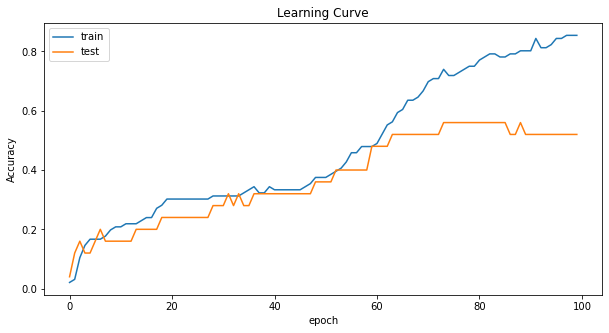

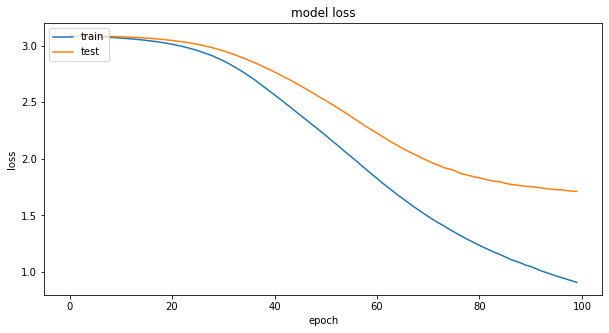

In [77]:
# #plotting model accuracy
# plt.plot(train_sw.history['accuracy'], label="training set accuracy")
# plt.plot(train_sw.history["loss"], label ="training set loss")
# plt.legend()

plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
lstm_model.save('../modeles/lstm_model_tts.h5')